In [ ]:
!pip install pyspark 

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 51.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=0aa630082e9d47315c08cefc04f8e311d8a36263199d53d884f786a693a1f167
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
pip install findspark

In [ ]:
import findspark

In [ ]:
from pyspark.sql import SparkSession,DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.sql import SparkSession 

from textblob import TextBlob
import re
from nltk.tokenize import WordPunctTokenizer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import os, tempfile
import csv
import string
import random

**importer les données**

In [ ]:
#Load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/Tweets_March.csv'

In [ ]:
train= pd.read_csv(path)
train.head()

,Unnamed: 0,Datetime,Tweet Id,Text,Username,Like Count,Display Name,Language
0,0,2021-02-27 23:59:59+00:00,1365813964756692993,Are you ready to roll your sleeve up for the C...,USAGov,3,USAGov,en
1,1,2021-02-27 23:59:59+00:00,1365813964320501767,"I've been trying to tweet about Dr Yeadon, for...",seeker375,0,Matthew,en
2,2,2021-02-27 23:59:58+00:00,1365813962739179523,U.S. authorizes Johnson &amp; Johnson’s COVID-...,The_StreetPress,0,The Street Press,en
3,3,2021-02-27 23:59:58+00:00,1365813959333318656,The Food and Drug Administration has authorize...,Richard31225984,0,Demosthenies MAN / MAN,en
4,4,2021-02-27 23:59:57+00:00,1365813958163111938,"@AP There’s three COVID-19 vaccines but Flint,...",NxtLevelPromo_,36,NxtLevelPromo,en


In [ ]:
 train.drop(7,0,inplace=True)

**nettoyage des données**

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

#supprimer les valeurs manquantes
train.dropna(axis=0,inplace=True) 

#features selection
train = pd.DataFrame(train[['Tweet Id', 'Text']])

#w=[a-zA-Z0-9_]
train['content'] = train['Text'].map(lambda x: re.sub(r'\W+', ' ', x)) #supprimer les hashtags
train['content'] = train['Text'].replace(r'\W+', ' ', regex=True) #représenter le texte par des expressions régulières

#Contraction
contraction = {'cause':'because',
              'aint': 'am not',
              'aren\'t': 'are not'}
def mapping_replacer(x,dic):
    for words in dic.keys():
        if ' ' + words + ' ' in x:
            x=x.replace(' '+ words +' ' ,' '+dic[words]+' ' )
    return x

#Racine, lemmatisation et tokenisation 
from nltk.tokenize import word_tokenize #renvoie en fait les syllabes d'un seul mot.
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

#La différence entre la radicalisation et la lemmatisation est que la radicalisation est plus rapide car elle coupe 
#les mots sans connaître le contexte, tandis que la lemmatisation est plus lente car elle connaît le contexte des mots avant le traitement. 

nltk.LancasterStemmer
ls = LancasterStemmer()
lem = WordNetLemmatizer()

def lexicon_normalization(text):
    words = word_tokenize(text)  
    # 1- Stemming (radicalisme )
    words_stem = [ls.stem(w) for w in words] 
    # 2- Lemmatization
    words_lem = [lem.lemmatize(w) for w in words_stem]
    return words_lem 

#Suppression des liens, crochets, chiffres, ponctuations, etc. 
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower() #make text lowercase
    text = re.sub('\[.*?\]', '', text) #remove square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #remove https www links
    text = re.sub(r"http\S+", "",text) #remove http links
    text = re.sub(r'bit.ly/\S+', '', text)  # remove bitly links
    text = re.sub('<.*?>+', '', text) #remove ponctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text) #le retour à la ligne
    text = re.sub('\w*\d\w*', '', text) 
    text = re.sub('\'','', text)
    return text 

#remove stopwords
from collections import Counter
from nltk.corpus import stopwords

nltk.download('stopwords')
def remove_stopword(text):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return text

train['content']=train['content'].apply(lambda x: mapping_replacer(x, contraction))
train['content'] = train['content'].apply(lambda x:clean_text(x))
train['content']=train['content'].apply(lambda x: remove_stopword(x))
train['content']=train['content'].apply(lambda x: lexicon_normalization(x))
train.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Tweet Id,Text,content
0,1365813964756692993,Are you ready to roll your sleeve up for the C...,"[ready, rol, sleev, covid, vaccin, stat, reg, ..."
1,1365813964320501767,"I've been trying to tweet about Dr Yeadon, for...","[try, tweet, dr, yeadon, long, tim, day, allow..."
2,1365813962739179523,U.S. authorizes Johnson &amp; Johnson’s COVID-...,"[u, auth, johnson, amp, johnson, covid, vaccin..."
3,1365813959333318656,The Food and Drug Administration has authorize...,"[food, drug, admin, auth, johnson, amp, johnso..."
4,1365813958163111938,"@AP There’s three COVID-19 vaccines but Flint,...","[ap, three, covid, vaccin, flint, michig, stil..."


**Trouver les mots les plus courants**

In [ ]:
top = Counter([item for sublist in train['content'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,vaccin,11887
1,covid,10237
2,co,7343
3,johnson,2877
4,amp,2351
5,u,2281
6,get,2207
7,do,2002
8,shot,1309
9,fda,1089


**analyse des sentiments**

In [ ]:
#Textblob to analysis the polarity and subjectivity

def get_tweet_sentiment(tweet): 

    # create TextBlob object of passed tweet text 
    analysis = TextBlob(tweet) 
    
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0: 
        return 0
    else: 
        return -1

In [ ]:
train['sentiment']=train['content'].apply(lambda x: get_tweet_sentiment(' '.join(x)))

In [ ]:
Positive_sent = train[train['sentiment']==1]
Negative_sent = train[train['sentiment']==0]
Neutral_sent = train[train['sentiment']==-1]

print('Number of tweets with positive sentiment', Positive_sent['sentiment'].count())
print('Number of tweets with negative sentiment', Negative_sent['sentiment'].count())
print('Number of tweets with neutral sentiment', Neutral_sent['sentiment'].count())

Number of tweets with positive sentiment 3597
Number of tweets with negative sentiment 4916
Number of tweets with neutral sentiment 1487


**la visualisation**

In [ ]:
!pip install plotly
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

temp = train.groupby('sentiment').count()['content'].reset_index().sort_values(by='content',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,content
1,0,4916
2,1,3597
0,-1,1487


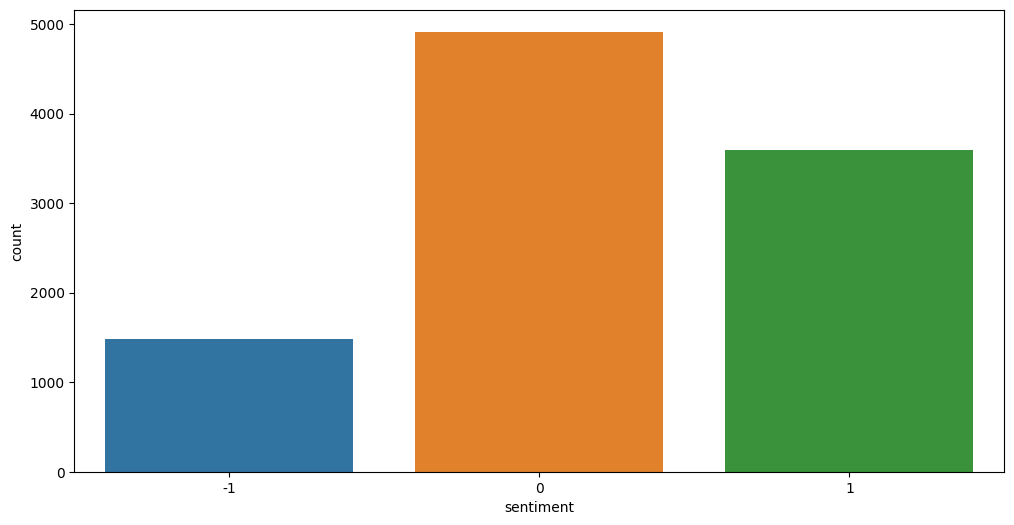

In [ ]:
#positive,negative and neutral tweet
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.content,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

**Lire les données avec Pyspark**

In [ ]:
train.to_csv('TweetsCleaned.csv')
spark=SparkSession.builder.getOrCreate()
df=spark.read.csv('TweetsCleaned.csv',inferSchema=True,header=True)
df.show()

+--------------------+--------------------+--------------------+--------------------+---------+
|                 _c0|            Tweet Id|                Text|             content|sentiment|
+--------------------+--------------------+--------------------+--------------------+---------+
|                   0| 1365813964756692993|Are you ready to ...|                null|     null|
|Each state has it...|                null|                null|                null|     null|
|Learn about the C...|['ready', 'rol', ...|                   1|                null|     null|
|                   1| 1365813964320501767|"I've been trying...|['try', 'tweet', ...|       -1|
|                   2| 1365813962739179523|U.S. authorizes J...|['u', 'auth', 'jo...|        0|
|                   3| 1365813959333318656|The Food and Drug...|                null|     null|
|Lets see how Trud...|['food', 'drug', ...|                  -1|                null|     null|
|                   4| 13658139581631119

In [ ]:
#Afin de nettoyer l’ensemble de données, nous devons supprimer toutes les valeurs nulles dans le cadre de données. 
df1=df.na.drop(how="any")
df1.show()

+---+-------------------+--------------------+--------------------+---------+
|_c0|           Tweet Id|                Text|             content|sentiment|
+---+-------------------+--------------------+--------------------+---------+
|  1|1365813964320501767|"I've been trying...|['try', 'tweet', ...|       -1|
|  2|1365813962739179523|U.S. authorizes J...|['u', 'auth', 'jo...|        0|
|  4|1365813958163111938|@AP There’s three...|['ap', 'three', '...|        0|
|  5|1365813951544623106|"""FDA grants eme...|['fda', 'grant', ...|        0|
|  6|1365813925082763266|Johnson &amp; Joh...|['johnson', 'amp'...|        0|
|  8|1365813878995759108|https://t.co/5CRx...|['co', 'fda', 'is...|        0|
|  9|1365813869608902658|We have a new #CO...|['new', 'covidvac...|        1|
| 10|1365813863623651329|"""FDA grants eme...|['fda', 'grant', ...|        0|
| 12|1365813860515643394|"""FDA grants eme...|['fda', 'grant', ...|        0|
| 13|1365813855524433924|FDA approves John...|['fda', 'approv',.

In [ ]:
df2=df1.select('content',col("sentiment"))
df2.show() 

+--------------------+---------+
|             content|sentiment|
+--------------------+---------+
|['try', 'tweet', ...|       -1|
|['u', 'auth', 'jo...|        0|
|['ap', 'three', '...|        0|
|['fda', 'grant', ...|        0|
|['johnson', 'amp'...|        0|
|['co', 'fda', 'is...|        0|
|['new', 'covidvac...|        1|
|['fda', 'grant', ...|        0|
|['fda', 'grant', ...|        0|
|['fda', 'approv',...|        0|
|['fda', 'issu', '...|        0|
|['johnson', 'amp'...|        0|
|['co', 'johnson',...|        1|
|['fda', 'auth', '...|        0|
|['fda', 'approv',...|        0|
|['oklahom', 'vacc...|        1|
|['icym', 'mad', '...|       -1|
|['bet', 'anyth', ...|        0|
|['three', 'helenb...|        1|
|['sosopriceless',...|        0|
+--------------------+---------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="content", outputCol="words", pattern="\\W")

# bag of words count
countVectors = CountVectorizer(inputCol="words", outputCol="features", vocabSize=20000, minDF=5)

In [ ]:
#sentiment est une colonne avec 3 étiquettes différentes (0 -1 1)
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df2)
dataset = pipelineFit.transform(df2)
dataset.show(5) 

+--------------------+---------+--------------------+--------------------+-----+
|             content|sentiment|               words|            features|label|
+--------------------+---------+--------------------+--------------------+-----+
|['try', 'tweet', ...|       -1|[try, tweet, dr, ...|(2134,[0,1,4,42,4...|  2.0|
|['u', 'auth', 'jo...|        0|[u, auth, johnson...|(2134,[0,1,2,3,4,...|  0.0|
|['ap', 'three', '...|        0|[ap, three, covid...|(2134,[0,1,49,196...|  0.0|
|['fda', 'grant', ...|        0|[fda, grant, emer...|(2134,[0,1,2,3,4,...|  0.0|
|['johnson', 'amp'...|        0|[johnson, amp, jo...|(2134,[0,1,2,3,4,...|  0.0|
+--------------------+---------+--------------------+--------------------+-----+
only showing top 5 rows



**Partition Training and Test sets**

In [ ]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 5443
Test Dataset Count: 2336


**La régression logistique**

In [ ]:
#logistique regression

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("content","sentiment","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+---------+------------------------------+-----+----------+
|                       content|sentiment|                   probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
|['guy', 'put', 'covid', 'va...|        0|[0.9692912696661593,0.00721...|  0.0|       0.0|
|['la', 'covid', 'continu', ...|        0|[0.9617298978179727,0.01733...|  0.0|       0.0|
|['amahoro', 'thierryu', 'zz...|        0|[0.9562763527838907,0.02766...|  0.0|       0.0|
|['marshablackburn', 'mayb',...|       -1|[0.952404467019966,0.010397...|  2.0|       0.0|
|['look', 'germany', 'americ...|        0|[0.9431182003844467,0.02868...|  0.0|       0.0|
|['beltway', 'insid', 'bid',...|        0|[0.9428546165671369,0.03082...|  0.0|       0.0|
|['beltway', 'insid', 'bid',...|        0|[0.9428546165671369,0.03082...|  0.0|       0.0|
|['beltway', 'insid', 'bid',...|        0|[0.9428546165671369,0.03082...|  0.0|       0.0|

**Evaluation du modèle**

In [ ]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Accuracy
model_acc = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")
print("LR classifier Accuracy (test) = %g" % model_acc.evaluate(predictions))

#F1-score
model_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="f1")
model_f1.evaluate(predictions) 
print("LR classifier F1 (test) = %g" % model_f1.evaluate(predictions))

#weightedPrecision
model_precision = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedPrecision")
model_precision.evaluate(predictions) 
print("LR classifier weightedPrecision (test) = %g" % model_precision.evaluate(predictions))

#weightedRecall
model_recall = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedRecall")
model_recall.evaluate(predictions)
print("LR classifier weightedRecall (test) = %g" % model_recall.evaluate(predictions))

LR classifier Accuracy (test) = 0.806935
LR classifier F1 (test) = 0.791702
LR classifier weightedPrecision (test) = 0.80467
LR classifier weightedRecall (test) = 0.806935
